In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, 
    precision_score, recall_score, roc_auc_score,
    precision_recall_curve, average_precision_score,
    roc_curve
)

# Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Gestion du déséquilibre
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.combine import SMOTEENN

# Configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline


In [2]:
print("Chargement des données nettoyées\n")
df_train = pd.read_csv('data_train_cleaned.csv')
df_test = pd.read_csv('data_test_cleaned.csv')


Chargement des données nettoyées



In [3]:
print("PRÉPARATION DES FEATURES")
print("="*70)

# Colonnes à exclure
exclude_cols = ['ZIBZIN', 'IDAvisAutorisationCheque', 'FlagImpaye', 
                'DateTransaction', 'CodeDecision','VerifianceCPT2', 'VerifianceCPT3']

# Si 'Mois' et 'Date' existent (créés dans le notebook EDA), les exclure aussi
if 'Mois' in df_train.columns:
    exclude_cols.append('Mois')
if 'Date' in df_train.columns:
    exclude_cols.append('Date')

# Features disponibles
feature_cols = [col for col in df_train.columns if col not in exclude_cols]

print(f"\nFeatures sélectionnées ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f" {i:2d}. {col}")

print(f"\n Colonnes exclues: {exclude_cols}")
print(" CodeDecision exclu car information post-transaction = FUITE!")

# Créer X et y
X_train = df_train[feature_cols].copy()
y_train = df_train['FlagImpaye'].copy()

X_test = df_test[feature_cols].copy()
y_test = df_test['FlagImpaye'].copy()

print(f"\n✓ Features extraites:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test:  {X_test.shape}")

PRÉPARATION DES FEATURES

Features sélectionnées (16):
  1. Montant
  2. VerifianceCPT1
  3. D2CB
  4. ScoringFP1
  5. ScoringFP2
  6. ScoringFP3
  7. TauxImpNb_RB
  8. TauxImpNB_CPM
  9. EcartNumCheq
 10. NbrMagasin3J
 11. DiffDateTr1
 12. DiffDateTr2
 13. DiffDateTr3
 14. CA3TRetMtt
 15. CA3TR
 16. Heure

 Colonnes exclues: ['ZIBZIN', 'IDAvisAutorisationCheque', 'FlagImpaye', 'DateTransaction', 'CodeDecision', 'VerifianceCPT2', 'VerifianceCPT3', 'Mois', 'Date']
 CodeDecision exclu car information post-transaction = FUITE!

✓ Features extraites:
  X_train: (3888468, 16)
  X_test:  (737068, 16)


In [4]:
# Imputation des valeurs manquantes
print("\nImputation des valeurs manquantes...")
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)
print("Imputation terminée")




Imputation des valeurs manquantes...
Imputation terminée


In [5]:
# Normalisation
print("\nNormalisation (StandardScaler)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
print("Normalisation terminée")

print(f"\nPréparation terminée!")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled:  {X_test_scaled.shape}")
print(f"y_train: Fraudes = {(y_train==1).sum():,} / {len(y_train):,}")
print(f"y_test:  Fraudes = {(y_test==1).sum():,} / {len(y_test):,}")


Normalisation (StandardScaler)...
Normalisation terminée

Préparation terminée!
X_train_scaled: (3888468, 16)
X_test_scaled:  (737068, 16)
y_train: Fraudes = 23,346 / 3,888,468
y_test:  Fraudes = 6,485 / 737,068


In [6]:
def evaluate_model(model, X_test, y_test, model_name, verbose=True):
    """
    Évalue un modèle et retourne les métriques
    
    Parameters:
    -----------
    model : sklearn model
        Modèle entraîné
    X_test : array-like
        Features de test
    y_test : array-like
        Labels de test
    model_name : str
        Nom du modèle
    verbose : bool
        Afficher les résultats détaillés
    
    Returns:
    --------
    dict : Dictionnaire avec les métriques
    """
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Calculer les métriques
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    if verbose:
        print(f"RÉSULTATS - {model_name}")
        print(f"F1-score:  {f1:.4f} ")
        print(f"Précision: {precision:.4f}")
        print(f"Rappel:    {recall:.4f}")
        print(f"\nMatrice de confusion:")
        print(f"  TN: {tn:,}  |  FP: {fp:,}")
        print(f"  FN: {fn:,}  |  TP: {tp:,}")
        print(f"\nInterprétation:")
        print(f"  • Vraies fraudes détectées (TP): {tp:,}")
        print(f"  • Fraudes manquées (FN): {fn:,}")
        print(f"  • Fausses alarmes (FP): {fp:,}")
    
    return {
        'model': model_name,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'tp': int(tp),
        'fp': int(fp),
        'fn': int(fn),
        'tn': int(tn)
    }

print("Fonction d'évaluation définie")

Fonction d'évaluation définie


## Modélisation


In [7]:
# Initialiser la liste des résultats
results = []

### Logistic Regression + class_weight

In [8]:
print("Logistic Regression")
#approche cost-sensitive: donne plus de poids à la classe minoritaire
model1 = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model1.fit(X_train_scaled, y_train)
print("Entraînement terminé")

result1 = evaluate_model(model1, X_test_scaled, y_test, "LogReg + class_weight")
results.append(result1)

Logistic Regression
Entraînement terminé
RÉSULTATS - LogReg + class_weight
F1-score:  0.0386 
Précision: 0.0200
Rappel:    0.5806

Matrice de confusion:
  TN: 545,877  |  FP: 184,706
  FN: 2,720  |  TP: 3,765

Interprétation:
  • Vraies fraudes détectées (TP): 3,765
  • Fraudes manquées (FN): 2,720
  • Fausses alarmes (FP): 184,706


### Random Forest + class_weight

In [9]:
print("Random Forest")
#Ensemble d'arbres avec pondération des classes

model2 = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
model2.fit(X_train_scaled, y_train)

result2 = evaluate_model(model2, X_test_scaled, y_test, "RandomForest + class_weight")
results.append(result2)

Random Forest
RÉSULTATS - RandomForest + class_weight
F1-score:  0.0362 
Précision: 0.0186
Rappel:    0.6534

Matrice de confusion:
  TN: 507,126  |  FP: 223,457
  FN: 2,248  |  TP: 4,237

Interprétation:
  • Vraies fraudes détectées (TP): 4,237
  • Fraudes manquées (FN): 2,248
  • Fausses alarmes (FP): 223,457


### SMOTE + Logistic Regression

In [10]:
print("Logistic Regression")
#Génération d'exemples synthétiques de la classe minoritaire

# SMOTE
smote = SMOTE(sampling_strategy=0.1, random_state=42)  # 10% du ratio
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Taille après SMOTE: {X_train_smote.shape[0]:,} exemples")
print(f"Fraudes: {(y_train_smote==1).sum():,} ({(y_train_smote==1).sum()/len(y_train_smote)*100:.1f}%)")
model3 = LogisticRegression(max_iter=1000, random_state=42)
model3.fit(X_train_smote, y_train_smote)
print("Entraînement terminé")

result3 = evaluate_model(model3, X_test_scaled, y_test, "SMOTE + LogReg")
results.append(result3)

Logistic Regression
Taille après SMOTE: 4,251,634 exemples
Fraudes: 386,512 (9.1%)
Entraînement terminé
RÉSULTATS - SMOTE + LogReg
F1-score:  0.0941 
Précision: 0.1557
Rappel:    0.0674

Matrice de confusion:
  TN: 728,213  |  FP: 2,370
  FN: 6,048  |  TP: 437

Interprétation:
  • Vraies fraudes détectées (TP): 437
  • Fraudes manquées (FN): 6,048
  • Fausses alarmes (FP): 2,370


### RandomUnderSampler + Logistic Regression

In [11]:
print("MÉTHODE 5: RandomUnderSampler (under-sampling) + Logistic Regression")
#Réduction de la classe majoritaire

# Under-sampling
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

print(f"Taille après under-sampling: {X_train_rus.shape[0]:,} exemples")
print(f"Fraudes: {(y_train_rus==1).sum():,} ({(y_train_rus==1).sum()/len(y_train_rus)*100:.1f}%)")
model4 = LogisticRegression(max_iter=1000, random_state=42)
model4.fit(X_train_rus, y_train_rus)
result4 = evaluate_model(model4, X_test_scaled, y_test, "UnderSampling + LogReg")
results.append(result4)

MÉTHODE 5: RandomUnderSampler (under-sampling) + Logistic Regression
Taille après under-sampling: 70,038 exemples
Fraudes: 23,346 (33.3%)
RÉSULTATS - UnderSampling + LogReg
F1-score:  0.0670 
Précision: 0.0370
Rappel:    0.3553

Matrice de confusion:
  TN: 670,566  |  FP: 60,017
  FN: 4,181  |  TP: 2,304

Interprétation:
  • Vraies fraudes détectées (TP): 2,304
  • Fraudes manquées (FN): 4,181
  • Fausses alarmes (FP): 60,017


### Balanced Random Forest

In [12]:
print("Balanced Random Forest (imblearn)")
#Random Forest spécialement conçu pour données déséquilibrées

model5 = BalancedRandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
model5.fit(X_train_scaled, y_train)
result5 = evaluate_model(model5, X_test_scaled, y_test, "BalancedRandomForest")
results.append(result5)

Balanced Random Forest (imblearn)
RÉSULTATS - BalancedRandomForest
F1-score:  0.0350 
Précision: 0.0180
Rappel:    0.6848

Matrice de confusion:
  TN: 487,793  |  FP: 242,790
  FN: 2,044  |  TP: 4,441

Interprétation:
  • Vraies fraudes détectées (TP): 4,441
  • Fraudes manquées (FN): 2,044
  • Fausses alarmes (FP): 242,790


## XGBoost + SMOTE

In [13]:
#  XGBoost + SMOTE (BONUS - Plus performant)


print("XGBoost + SMOTE")
#"Gradient Boosting optimisé (XGBoost) avec sur-échantillonnage

# Installer XGBoost si pas encore fait (décommenter si nécessaire)
# !pip install xgboost --break-system-packages

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Taille après SMOTE: {X_train_smote.shape[0]:,} exemples")
print(f"Fraudes: {(y_train_smote==1).sum():,} ({(y_train_smote==1).sum()/len(y_train_smote)*100:.1f}%)")

# Configuration XGBoost (optimisée pour gros datasets)
model6 = XGBClassifier(
    n_estimators=100,        # Nombre d'arbres (réduit pour vitesse)
    max_depth=5,            # Profondeur max
    learning_rate=0.1,      # Taux d'apprentissage
    subsample=0.8,          # Sous-échantillonnage pour régularisation
    colsample_bytree=0.8,   # Sous-échantillonnage des features
    random_state=42,
    eval_metric='logloss',  # Métrique d'évaluation
    tree_method='hist',     # Méthode rapide pour gros datasets
    n_jobs=-1               # Utiliser tous les CPU
)

model6.fit(X_train_smote, y_train_smote)
# Évaluation avec la fonction existante
result6 = evaluate_model(model6, X_test_scaled, y_test, "XGBoost + SMOTE")
results.append(result6)

XGBoost + SMOTE
Taille après SMOTE: 4,251,634 exemples
Fraudes: 386,512 (9.1%)
RÉSULTATS - XGBoost + SMOTE
F1-score:  0.1304 
Précision: 0.1568
Rappel:    0.1116

Matrice de confusion:
  TN: 726,690  |  FP: 3,893
  FN: 5,761  |  TP: 724

Interprétation:
  • Vraies fraudes détectées (TP): 724
  • Fraudes manquées (FN): 5,761
  • Fausses alarmes (FP): 3,893


In [28]:
# MÉTHODE 7: XGBoost + scale_pos_weight (optimisé pour déséquilibre) Version avec seuil optimisé ajoutée aux résultats

from sklearn.metrics import precision_recall_curve


# 1. Calcul du ratio d'équilibrage

nb_normales = (y_train == 0).sum()
nb_fraudes = (y_train == 1).sum()
ratio = float(nb_normales) / float(nb_fraudes)

print(f"Ratio de déséquilibre: 1:{ratio:.1f}")
print(f"scale_pos_weight = {ratio:.2f}")


# 2. Modèle XGBoost

model7 = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=ratio,      # ← Gère le déséquilibre automatiquement
    tree_method="hist",          # ← Très rapide sur gros datasets
    device="cpu",                # Mettre "cuda" si tu as un GPU
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'        # Évite les warnings
)

model7.fit(X_train_scaled, y_train)


# Évaluation avec la fonction standard

result7 = evaluate_model(model7, X_test_scaled, y_test, "XGBoost + scale_pos_weight")
results.append(result7)


# Optimisation du seuil (optionnel)
print("\n📊 Analyse du seuil optimal...")

# Obtenir les probabilités
y_probs_xgb = model7.predict_proba(X_test_scaled)[:, 1]

# Calculer la courbe precision-recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_xgb)

# Calculer F1 pour chaque seuil
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Trouver le meilleur seuil
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
best_f1 = f1_scores[best_idx]

print(f"Seuil par défaut (0.5): F1 = {result7['f1']:.4f}")
print(f"Seuil optimal ({best_threshold:.3f}): F1 = {best_f1:.4f}")

if best_f1 > result7['f1']:
    print(f"✨ Amélioration de {((best_f1/result7['f1'])-1)*100:.1f}% avec seuil optimisé!")

    # Optionnel: ajouter une version avec seuil optimisé
    y_pred_optimal = (y_probs_xgb >= best_threshold).astype(int)

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred_optimal)
    tn, fp, fn, tp = cm.ravel()

    result7_optimal = {
        'model': f"XGBoost (seuil={best_threshold:.3f})",
        'f1': best_f1,
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    }
    results.append(result7_optimal)

Ratio de déséquilibre: 1:165.6
scale_pos_weight = 165.56
RÉSULTATS - XGBoost + scale_pos_weight
F1-score:  0.0347 
Précision: 0.0178
Rappel:    0.6951

Matrice de confusion:
  TN: 481,677  |  FP: 248,906
  FN: 1,977  |  TP: 4,508

Interprétation:
  • Vraies fraudes détectées (TP): 4,508
  • Fraudes manquées (FN): 1,977
  • Fausses alarmes (FP): 248,906

📊 Analyse du seuil optimal...
Seuil par défaut (0.5): F1 = 0.0347
Seuil optimal (0.939): F1 = 0.1484
✨ Amélioration de 327.9% avec seuil optimisé!


## Comparaison des Résultats

In [29]:
print(" COMPARAISON FINALE DES 7 MÉTHODES")

# Créer un DataFrame de résultats
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('f1', ascending=False)

print("\n TABLEAU RÉCAPITULATIF (trié par F-mesure):\n")
print(results_df[['model', 'f1', 'precision', 'recall', 'tp', 'fp', 'fn']].to_string(index=False))

# Meilleur modèle
best_model = results_df.iloc[0]
print(f"\nMEILLEUR MODÈLE: {best_model['model']}")
print(f" F-mesure: {best_model['f1']:.4f}")
print(f" Précision: {best_model['precision']:.4f}")
print(f" Rappel: {best_model['recall']:.4f}")
print(f" TP (fraudes détectées): {best_model['tp']:,}")
print(f" FN (fraudes manquées): {best_model['fn']:,}")
print(f" FP (fausses alarmes): {best_model['fp']:,}")

 COMPARAISON FINALE DES 7 MÉTHODES

 TABLEAU RÉCAPITULATIF (trié par F-mesure):

                      model       f1  precision   recall   tp     fp   fn
      XGBoost (seuil=0.939) 0.148441   0.183911 0.124441  807   3581 5678
      XGBoost (seuil=0.939) 0.148441   0.183911 0.124441  807   3581 5678
            XGBoost + SMOTE 0.130427   0.156812 0.111642  724   3893 5761
             SMOTE + LogReg 0.094059   0.155682 0.067386  437   2370 6048
     UnderSampling + LogReg 0.066971   0.036970 0.355281 2304  60017 4181
      LogReg + class_weight 0.038624   0.019977 0.580571 3765 184706 2720
RandomForest + class_weight 0.036186   0.018608 0.653354 4237 223457 2248
       BalancedRandomForest 0.035008   0.017963 0.684811 4441 242790 2044
 XGBoost + scale_pos_weight 0.034690   0.017789 0.695143 4508 248906 1977
 XGBoost + scale_pos_weight 0.034690   0.017789 0.695143 4508 248906 1977

MEILLEUR MODÈLE: XGBoost (seuil=0.939)
 F-mesure: 0.1484
 Précision: 0.1839
 Rappel: 0.1244
 TP (fraudes

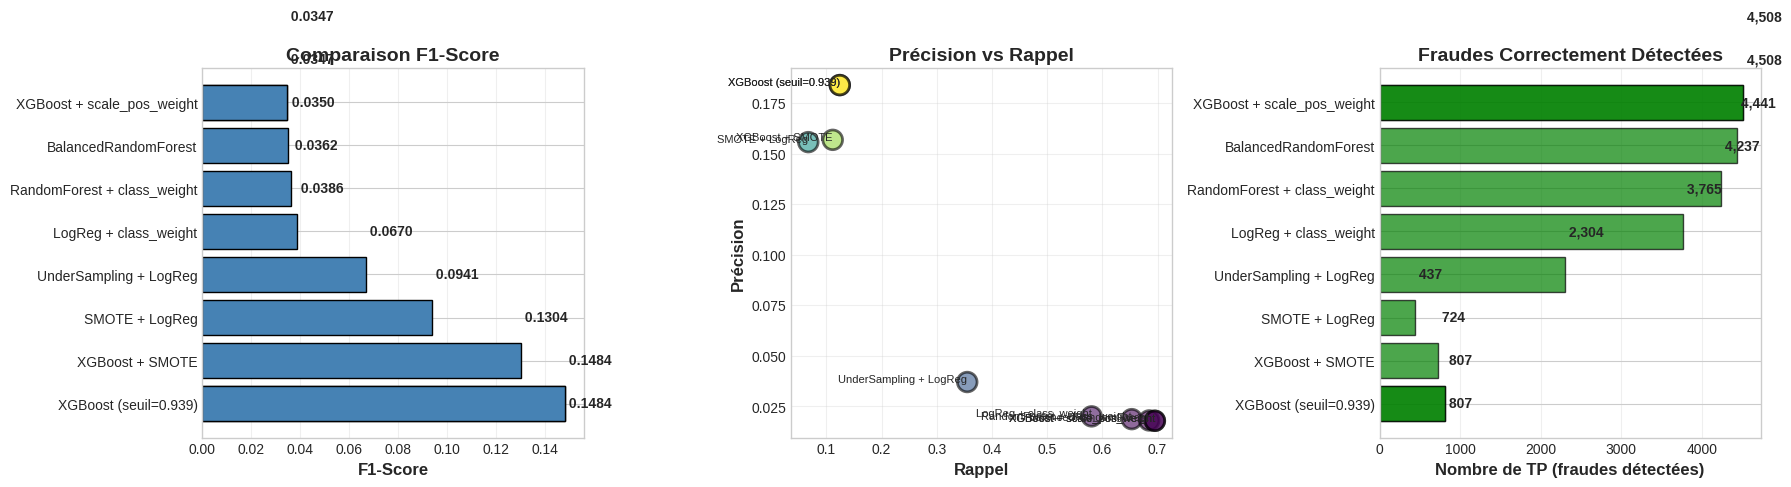

In [30]:
# Visualisation des résultats
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1-score
axes[0].barh(results_df['model'], results_df['f1'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes[0].set_title('Comparaison F1-Score', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['f1']):
    axes[0].text(v, i, f' {v:.4f}', va='center', fontweight='bold')

# Précision vs Rappel
axes[1].scatter(results_df['recall'], results_df['precision'], s=200, alpha=0.6, c=results_df['f1'], 
                cmap='viridis', edgecolors='black', linewidth=2)
for i, model in enumerate(results_df['model']):
    axes[1].annotate(model, (results_df.iloc[i]['recall'], results_df.iloc[i]['precision']),
                    fontsize=8, ha='right')
axes[1].set_xlabel('Rappel', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Précision', fontsize=12, fontweight='bold')
axes[1].set_title('Précision vs Rappel', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

# Nombre de TP (fraudes détectées)
axes[2].barh(results_df['model'], results_df['tp'], color='green', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Nombre de TP (fraudes détectées)', fontsize=12, fontweight='bold')
axes[2].set_title('Fraudes Correctement Détectées', fontsize=14, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['tp']):
    axes[2].text(v, i, f' {v:,}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Sauvegarde des Résultats

In [32]:
print("\n" + "="*80)
print("💾 SAUVEGARDE DES RÉSULTATS")
print("="*80)

# Calculer les statistiques nécessaires
train_fraudes = (y_train == 1).sum()
test_fraudes = (y_test == 1).sum()

# Sauvegarder le tableau de résultats
results_df.to_csv('resultats_modelisation_partie1.csv', index=False)
print("\nRésultats sauvegardés: resultats_modelisation_partie1.csv")

# Créer un résumé textuel
with open('resume_modelisation.txt', 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("RÉSUMÉ - MODÉLISATION PARTIE 1: MAXIMISATION F-MESURE\n")
    f.write("="*80 + "\n\n")

    f.write("DATASET:\n")
    f.write(f"  Train: {len(y_train):,} transactions ({train_fraudes:,} fraudes - {train_fraudes/len(y_train)*100:.2f}%)\n")
    f.write(f"  Test:  {len(y_test):,} transactions ({test_fraudes:,} fraudes - {test_fraudes/len(y_test)*100:.2f}%)\n")
    f.write(f"  Features utilisées: {len(feature_cols)}\n")
    f.write(f"  Ratio de déséquilibre: 1:{(len(y_train)-train_fraudes)/train_fraudes:.1f}\n\n")

    f.write("RÉSULTATS PAR MODÈLE (triés par F-mesure):\n")
    f.write("-"*80 + "\n")
    f.write(results_df[['model', 'f1', 'precision', 'recall', 'tp', 'fn', 'fp']].to_string(index=False))

    f.write("\n\n" + "="*80 + "\n")
    f.write(f"🏆 MEILLEUR MODÈLE: {best_model['model']}\n")
    f.write("="*80 + "\n")
    f.write(f"  F-mesure:  {best_model['f1']:.4f}\n")
    f.write(f"  Précision: {best_model['precision']:.4f}\n")
    f.write(f"  Rappel:    {best_model['recall']:.4f}\n\n")

    f.write("DÉTAILS DE LA MATRICE DE CONFUSION:\n")
    f.write(f"  TP (fraudes correctement détectées): {best_model['tp']:,}\n")
    f.write(f"  TN (transactions normales correctes): {best_model['tn']:,}\n")
    f.write(f"  FN (fraudes manquées):               {best_model['fn']:,}\n")
    f.write(f"  FP (fausses alarmes):                {best_model['fp']:,}\n\n")

    f.write("INTERPRÉTATION:\n")
    total_fraudes_reelles = best_model['tp'] + best_model['fn']
    taux_detection = (best_model['tp'] / total_fraudes_reelles * 100) if total_fraudes_reelles > 0 else 0
    f.write(f"  • Taux de détection: {taux_detection:.1f}% des fraudes détectées\n")
    f.write(f"  • Précision: sur {best_model['tp'] + best_model['fp']:,} transactions signalées, {best_model['tp']:,} sont vraiment frauduleuses\n")
    f.write(f"  • Impact métier: {best_model['fn']:,} fraudes passées inaperçues, {best_model['fp']:,} clients légitimes bloqués\n")

print("Résumé sauvegardé: resume_modelisation.txt")

print("TOUS LES RÉSULTATS ONT ÉTÉ SAUVEGARDÉS !")
print("\nFichiers créés:")
print(" resultats_modelisation_partie1.csv - Tableau complet des résultats")
print(" resume_modelisation.txt - Résumé détaillé en texte")



💾 SAUVEGARDE DES RÉSULTATS

Résultats sauvegardés: resultats_modelisation_partie1.csv
Résumé sauvegardé: resume_modelisation.txt
TOUS LES RÉSULTATS ONT ÉTÉ SAUVEGARDÉS !

Fichiers créés:
 resultats_modelisation_partie1.csv - Tableau complet des résultats
 resume_modelisation.txt - Résumé détaillé en texte
